In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import pandas as pd
import numpy as np
import math
from tensorflow import keras
from keras.callbacks import EarlyStopping


In [2]:
# Definir la métrica SSIM
def ssim_metric(y_true, y_pred):
    y_true = tf.clip_by_value(y_true, 0, 1)
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    ssim_value = tf.map_fn(lambda x: tf.image.ssim(x[0], x[1], max_val=1.0), (y_true, y_pred), dtype=tf.float32)
    return tf.reduce_mean(ssim_value)

# Definir la métrica PSNR
def psnr_metric(y_true, y_pred):
    y_true = tf.clip_by_value(y_true, 0, 1)
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    psnr_value = tf.image.psnr(y_true, y_pred, max_val=1.0)
    return tf.reduce_mean(psnr_value)

In [3]:
# Ruta de los archivos DICOM
path_files = '/Users/charlesdaza/Downloads/IDA/PPMI/3D/1.5 Tesla/Sagital'
files_dcm = []

# Recorrer todas las carpetas y subcarpetas
for root, dirs, files in os.walk(path_files):
    images_dcm = [os.path.join(root, file) for file in files if file.endswith('.dcm')]
    images_dcm.sort(key=lambda x: int(pydicom.dcmread(x).InstanceNumber))
    files_dcm.extend(images_dcm)

# Comprobar la cantidad de archivos DICOM encontrados
print(f"Total de archivos DICOM encontrados: {len(files_dcm)}")

# Cargar imágenes que son exactamente de 256x256
images_mri = []
for archivo in files_dcm:
    img = pydicom.dcmread(archivo).pixel_array
    if img.shape == (256, 256):
        images_mri.append(img.astype(np.float32) / 255.0)  # Normalizar a [0, 1]

print(f"Total de imágenes de 256x256 encontradas: {len(images_mri)}")

if images_mri:
    high_img_mri = np.stack(images_mri, axis=0)
    print(f"Forma del volumen de imágenes: {high_img_mri.shape}")
else:
    print("No se encontraron imágenes de 256x256.")

Total de archivos DICOM encontrados: 55858
Total de imágenes de 256x256 encontradas: 31474
Forma del volumen de imágenes: (31474, 256, 256)


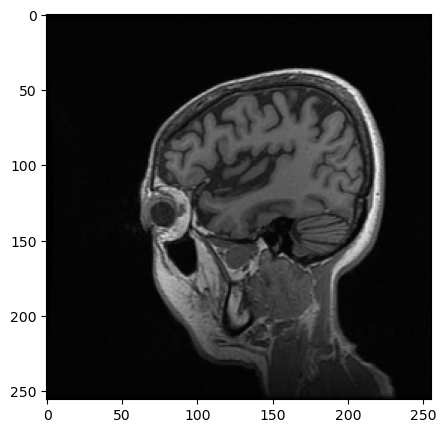

In [4]:
# Ver imágenes de resonancia magnética
plt.figure(figsize=(5, 5))
plt.imshow(high_img_mri[870], cmap='gray')

Forma de las imágenes de baja resolución: (31474, 256, 256)


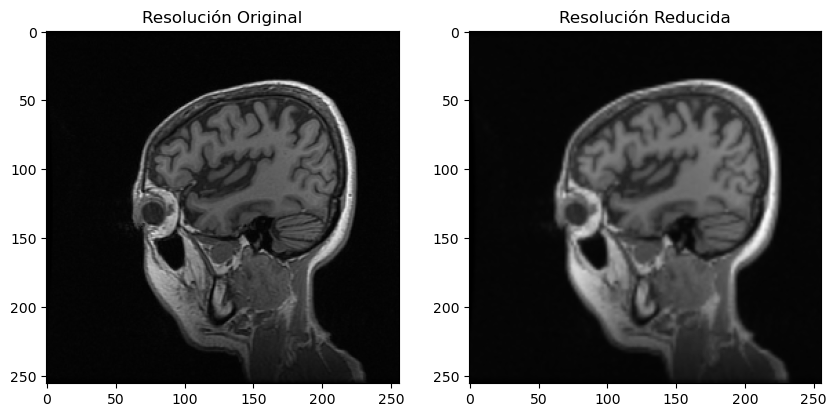

In [5]:
# Reducir resolución
def low_res_image(images, factor):
    if images is None or len(images) == 0:
        print("No hay imágenes válidas para procesar.")
        return None

    # Normalizar y procesar imágenes en un solo paso
    low_res_images = [
        cv2.resize(
            cv2.resize(image.astype(np.float32), 
                       (int(image.shape[1] * factor), int(image.shape[0] * factor)), 
                       interpolation=cv2.INTER_AREA),
            (image.shape[1], image.shape[0]), 
            interpolation=cv2.INTER_LINEAR
        ) / 255.0
        for image in images if image is not None and image.size > 0
    ]

    if not low_res_images:
        print("No se generaron imágenes de baja resolución.")
        return None

    return np.stack(low_res_images, axis=0)

# Factor de reducción de resolución
factor_res = 0.5

# Verificar si las imágenes de entrada son válidas
if high_img_mri is not None and high_img_mri.size > 0:
    low_img_mri = low_res_image(high_img_mri, factor_res)
    if low_img_mri is not None:
        print(f"Forma de las imágenes de baja resolución: {low_img_mri.shape}")
else:
    print("No hay imágenes válidas para procesar.")

# Visualización de una imagen de alta y baja resolución
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(high_img_mri[870], cmap='gray')
plt.title('Resolución Original')
plt.subplot(1, 2, 2)
plt.imshow(low_img_mri[870], cmap='gray')
plt.title('Resolución Reducida')
plt.show()

In [6]:
# Tamaño de las imágenes después del preprocesamiento
SIZE = 256

# Definir porcentajes para división de datos
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Total de imágenes
total_images = len(high_img_mri)

# Calcular índices para dividir los datos
train_end = int(total_images * train_ratio)
validation_end = train_end + int(total_images * validation_ratio)

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
train_high_mri, train_low_mri = high_img_mri[:train_end], low_img_mri[:train_end]
validation_high_mri, validation_low_mri = high_img_mri[train_end:validation_end], low_img_mri[train_end:validation_end]
test_high_mri, test_low_mri = high_img_mri[validation_end:], low_img_mri[validation_end:]

# Añadir una dimensión para cumplir con el formato de entrada del modelo
def add_channel_dimension(images):
    return np.reshape(images, (len(images), SIZE, SIZE, 1))

train_high_mri = add_channel_dimension(train_high_mri)
train_low_mri = add_channel_dimension(train_low_mri)
validation_high_mri = add_channel_dimension(validation_high_mri)
validation_low_mri = add_channel_dimension(validation_low_mri)
test_high_mri = add_channel_dimension(test_high_mri)
test_low_mri = add_channel_dimension(test_low_mri)

# Imprimir las formas de los conjuntos de datos
print("Shape of training mri:", train_high_mri.shape)
print("Shape of validation mri:", validation_high_mri.shape)
print("Shape of test mri:", test_high_mri.shape)

# Definir el modelo de downsample
def down(filters, kernel_size, apply_batch_normalization=True):
    downsample = tf.keras.models.Sequential([
        layers.Conv2D(filters, kernel_size, padding='same', strides=2),
        layers.BatchNormalization() if apply_batch_normalization else layers.Activation('linear'),
        layers.LeakyReLU()
    ])
    return downsample

# Definir el modelo de upsample
def up(filters, kernel_size, dropout=False):
    upsample = tf.keras.models.Sequential([
        layers.Conv2DTranspose(filters, kernel_size, padding='same', strides=2),
        layers.Dropout(0.2) if dropout else layers.Activation('linear'),
        layers.LeakyReLU()
    ])
    return upsample

Shape of training mri: (25179, 256, 256, 1)
Shape of validation mri: (3147, 256, 256, 1)
Shape of test mri: (3148, 256, 256, 1)


In [7]:

# Parámetros del modelo
low_res_image_height, low_res_image_width = 256, 256
channels = 1  # Escala de grises

# Número de iteraciones recursivas
num_recursive_layers = 20  # VDSR utiliza más capas recursivas que DRCN

# Definición del modelo VDSR
inputs = layers.Input(shape=(low_res_image_height, low_res_image_width, channels))

# Primera capa convolucional (extracción de características inicial)
feature_extraction = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)

# Capas recursivas
recursive_features = feature_extraction
for _ in range(num_recursive_layers):
    recursive_features = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(recursive_features)

# Reconstrucción (salida final)
output = layers.Conv2D(1, (3, 3), activation='linear', padding='same')(recursive_features)

# Crear el modelo
model = Model(inputs=[inputs], outputs=[output])

# Compilar el modelo con PSNR y SSIM como métricas
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mean_absolute_error',
    metrics=[ssim_metric, psnr_metric]  # Asegúrate de que ssim_metric y psnr_metric estén definidos
)

# Resumen del modelo
model.summary()



2025-05-23 17:31:59.858929: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-05-23 17:31:59.858953: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-05-23 17:31:59.858958: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-05-23 17:31:59.858973: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-23 17:31:59.858984: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 256, 256, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739,777 (2.82 MB)

 Trainable params: 739,777 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from datetime import datetime
# Ver la hora de inicio del entrenamiento
start_time = datetime.now()
print(f"Entrenamiento comenzó a las: {start_time.strftime('%H:%M:%S')}")

Entrenamiento comenzó a las: 17:32:00


In [9]:
history = model.fit(train_low_mri, train_high_mri, 
                    epochs=30,
                    batch_size=32, 
                    validation_data=(validation_low_mri, validation_high_mri))

Epoch 1/30


/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


Instructions for updating:
Use fn_output_signature instead


2025-05-23 17:32:19.504423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


787/787 ━━━━━━━━━━━━━━━━━━━━ 1264s 2s/step - loss: 0.2894 - psnr_metric: 20.3518 - ssim_metric: 0.5132 - val_loss: 0.0797 - val_psnr_metric: 28.1585 - val_ssim_metric: 0.7997
Epoch 2/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 1304s 2s/step - loss: 0.0756 - psnr_metric: 28.3170 - ssim_metric: 0.8061 - val_loss: 0.0645 - val_psnr_metric: 29.6947 - val_ssim_metric: 0.8439
Epoch 3/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 1309s 2s/step - loss: 0.0680 - psnr_metric: 29.1274 - ssim_metric: 0.8399 - val_loss: 0.0716 - val_psnr_metric: 28.5693 - val_ssim_metric: 0.8374
Epoch 4/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 1308s 2s/step - loss: 0.0675 - psnr_metric: 29.0889 - ssim_metric: 0.8414 - val_loss: 0.0659 - val_psnr_metric: 28.5182 - val_ssim_metric: 0.8399
Epoch 5/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 1303s 2s/step - loss: 0.0660 - psnr_metric: 29.2218 - ssim_metric: 0.8453 - val_loss: 0.0602 - val_psnr_metric: 30.0872 - val_ssim_metric: 0.8553
Epoch 6/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 1305s 2s/step - loss: 0.0634 - psnr_metri

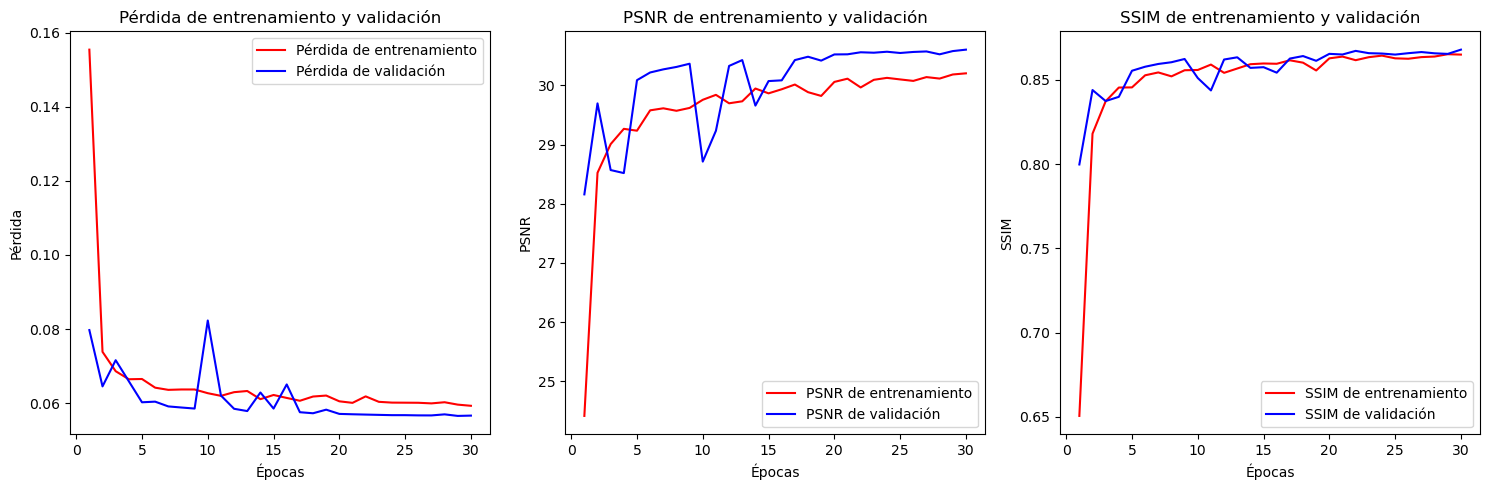

In [ ]:
# Obtener las métricas del historial de entrenamiento
loss = history.history['loss']
val_loss = history.history['val_loss']
psnr = history.history['psnr_metric']
val_psnr = history.history['val_psnr_metric']
ssim = history.history['ssim_metric']
val_ssim = history.history['val_ssim_metric']

epochs = range(1, len(loss) + 1)

# Crear una figura con 3 subgráficas en una fila
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Graficar la pérdida
axs[0].plot(epochs, loss, 'r', label='Pérdida de entrenamiento')
axs[0].plot(epochs, val_loss, 'b', label='Pérdida de validación')
axs[0].set_title('Pérdida de entrenamiento y validación')
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

# Graficar el PSNR
axs[1].plot(epochs, psnr, 'r', label='PSNR de entrenamiento')
axs[1].plot(epochs, val_psnr, 'b', label='PSNR de validación')
axs[1].set_title('PSNR de entrenamiento y validación')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('PSNR')
axs[1].legend()

# Graficar el SSIM
axs[2].plot(epochs, ssim, 'r', label='SSIM de entrenamiento')
axs[2].plot(epochs, val_ssim, 'b', label='SSIM de validación')
axs[2].set_title('SSIM de entrenamiento y validación')
axs[2].set_xlabel('Épocas')
axs[2].set_ylabel('SSIM')
axs[2].legend()

# Ajustar el layout
plt.tight_layout()
plt.show()

In [11]:

# Evaluación en el conjunto de validación
loss, psnr_value, ssim_value = model.evaluate(validation_low_mri, validation_high_mri)
print(f"Loss: {loss}")
print(f"PSNR: {ssim_value}")
print(f"SSIM: {psnr_value}")


99/99 ━━━━━━━━━━━━━━━━━━━━ 56s 569ms/step - loss: 0.0437 - psnr_metric: 31.2170 - ssim_metric: 0.8895
Loss: 0.05661364272236824
PSNR: 30.602561950683594
SSIM: 0.8678656816482544


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


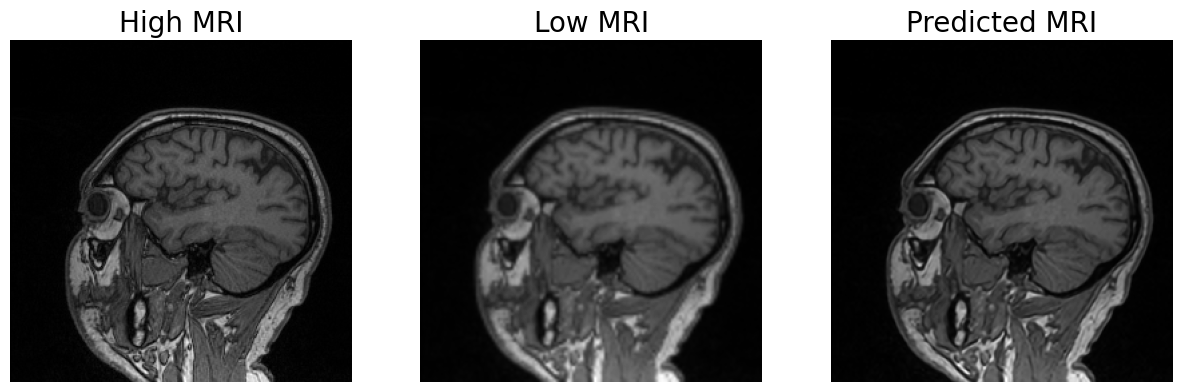

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


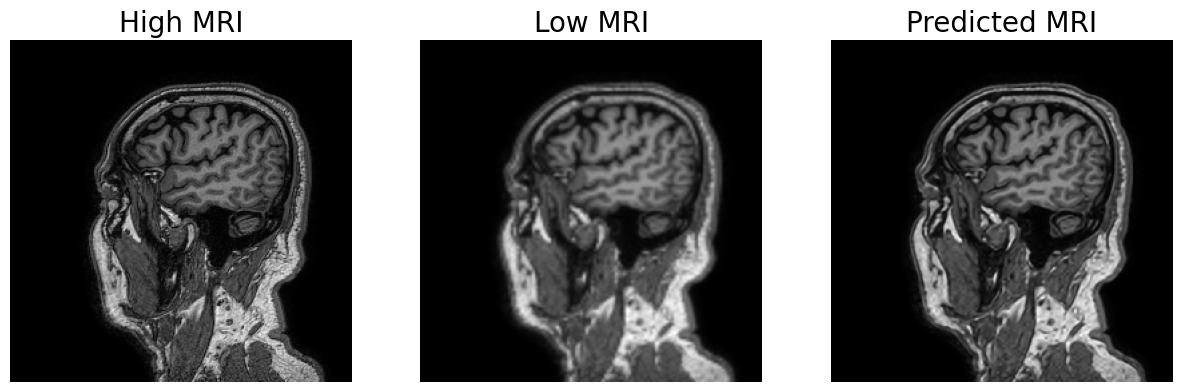

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


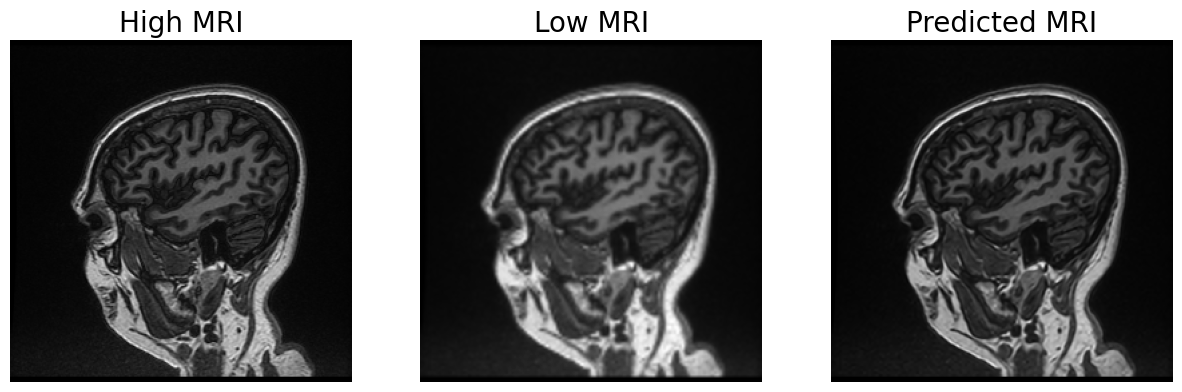

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


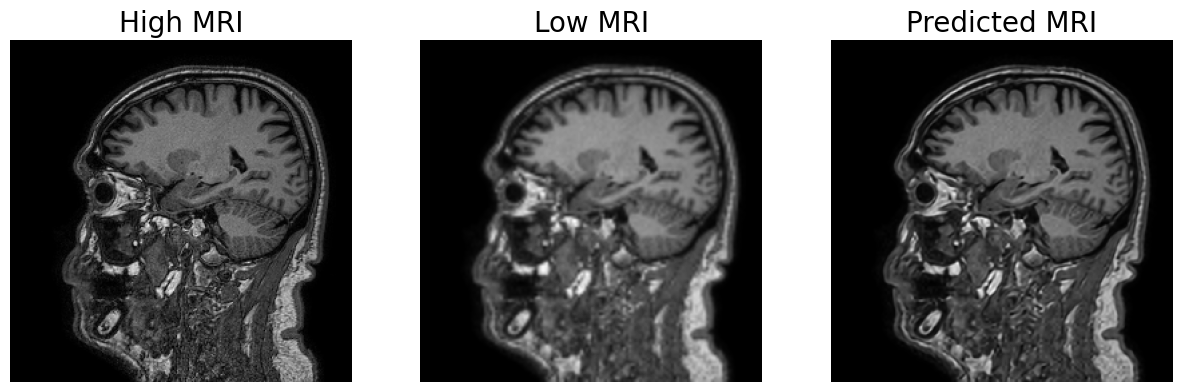

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


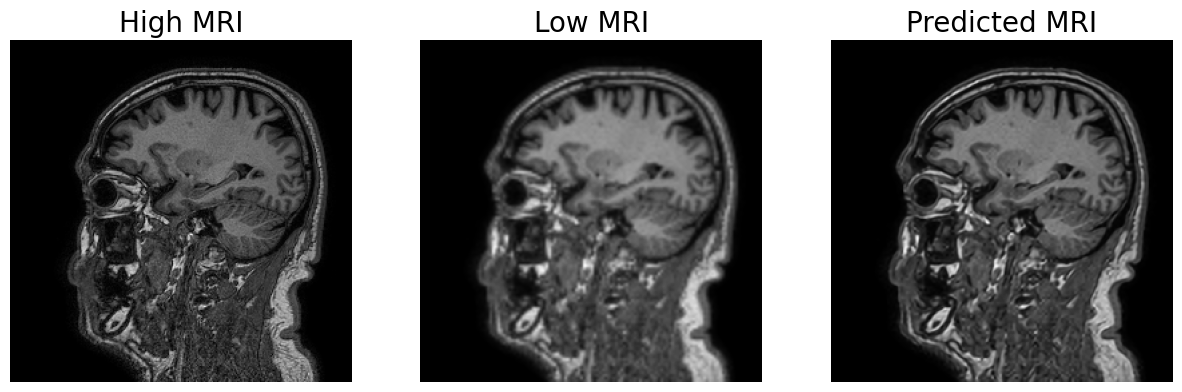

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


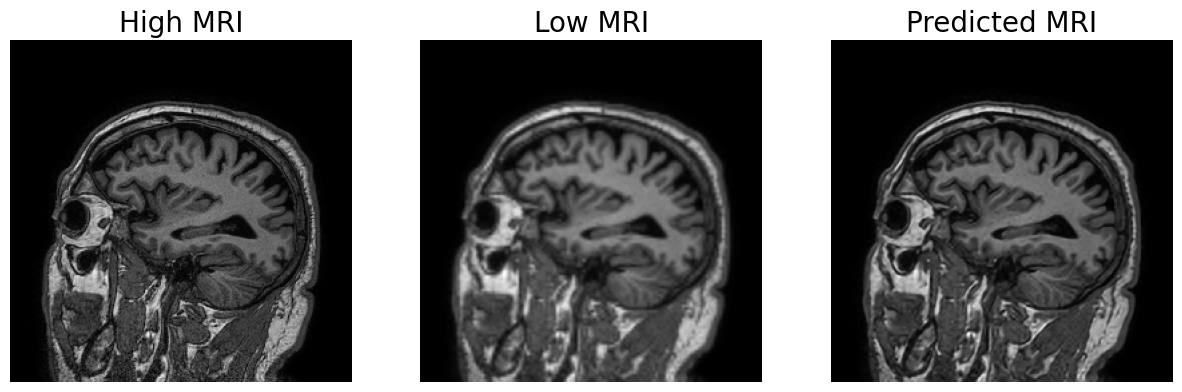

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


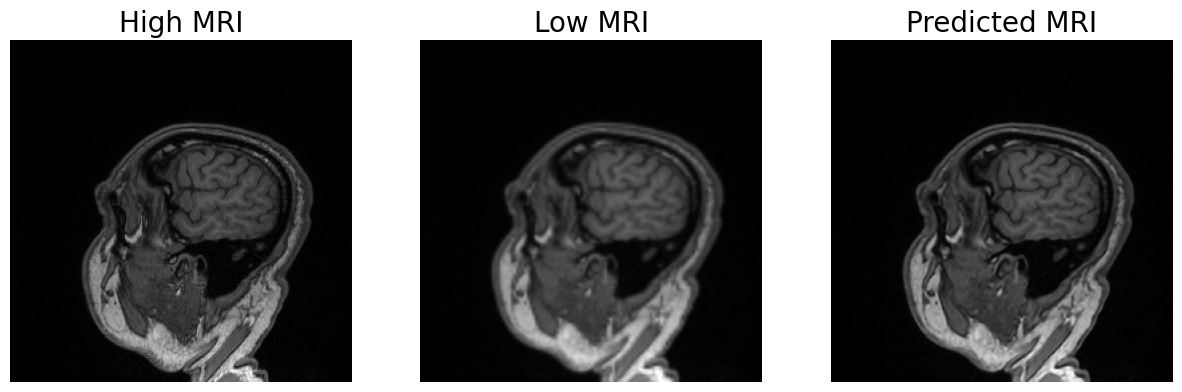

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


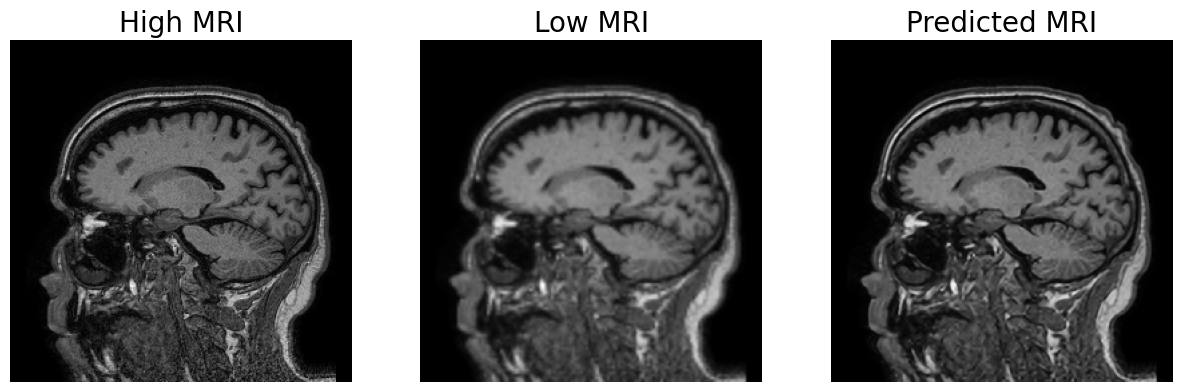

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


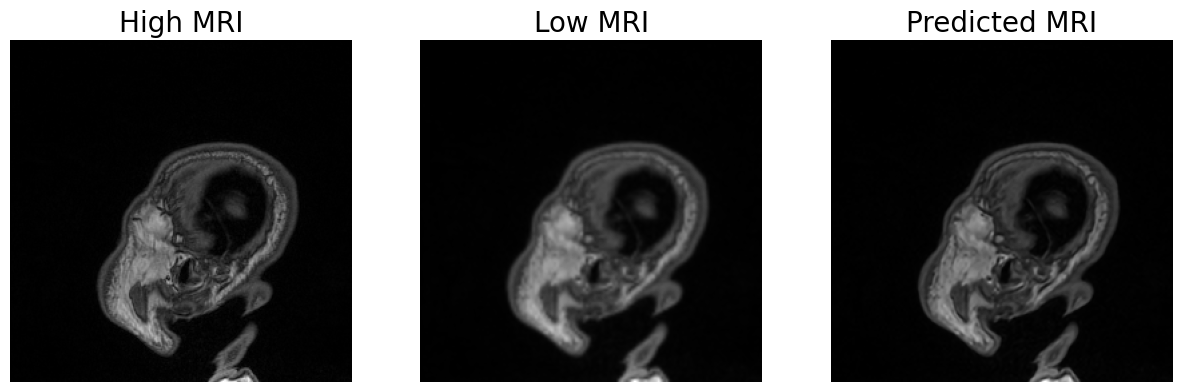

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


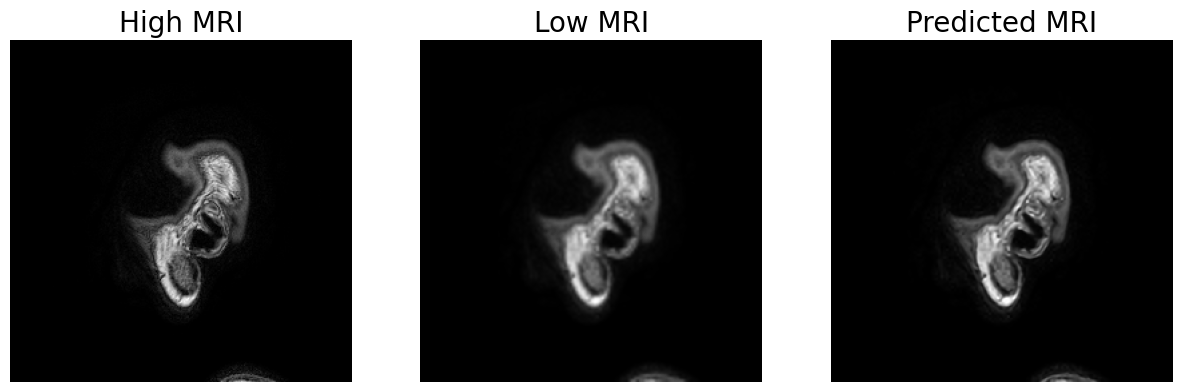

   Número de Imagen     PSNR    SSIM     MSE
0              3096  64.9938  0.9892  0.0206
1              2687  77.8380  0.9836  0.0011
2              1288  60.6374  0.9921  0.0561
3              2616  76.9056  0.9755  0.0013
4              2612  77.1266  0.9757  0.0013
5              1822  77.2316  0.9783  0.0012
6              3002  68.0621  0.9942  0.0102
7              2040  76.8563  0.9799  0.0013
8              3125  69.9652  0.9944  0.0066
9              1086  85.4723  0.9908  0.0002


In [ ]:
import random
# Comparativa imágenes
def psnr(target, ref):
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    diff = ref_data - target_data
    rmse = math.sqrt(np.mean(diff**2.))
    if rmse == 0:
        return float('inf')
    return 20 * math.log10(255. / rmse)

def ssim(target, ref):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    target = target.astype(np.float64)
    ref = ref.astype(np.float64)

    mu1 = np.mean(target)
    mu2 = np.mean(ref)
    sigma1 = np.std(target)
    sigma2 = np.std(ref)
    sigma12 = np.mean((target - mu1) * (ref - mu2))

    ssim_value = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1 ** 2 + sigma2 ** 2 + C2))
    return ssim_value

def mae(target, ref):
    return np.mean(np.abs(ref - target))

def mse(target, ref):
  return np.mean((ref.astype(np.float64) - target.astype(np.float64)) ** 2)

def compare_images(target, ref):
    target = np.clip(target, 0, 255)
    ref = np.clip(ref, 0, 255)
    if target.ndim == 3 and target.shape[-1] == 1:
        target = target.squeeze(-1)
    if ref.ndim == 3 and ref.shape[-1] == 1:
        ref = ref.squeeze(-1)
    psnr_score = psnr(target, ref)
    ssim_score = ssim(ref, target)
    mse_score = mse(ref, target)
    return [psnr_score, ssim_score, mse_score]

def plot_images(high, low, predicted):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title('High MRI', color='black', fontsize=20)
    plt.imshow(high, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Low MRI', color='black', fontsize=20)
    plt.imshow(low, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Predicted MRI', color='black', fontsize=20)
    plt.imshow(predicted, cmap='gray')
    plt.axis('off')
    plt.show()

# Lista para almacenar los resultados como diccionarios
results_data = []
indices = list(range(len(test_low_mri)))
random.shuffle(indices)

# Iterar sobre una muestra de índices
for i in indices[:10]:
    # Realizar la predicción
    predicted = model.predict(test_low_mri[i].reshape(1, SIZE, SIZE, 1))
    
    # Procesar la imagen predicha
    pred_img = predicted[0].squeeze()
    pred_img = np.clip(pred_img, 0, 255)
    
    # Comparar imágenes y obtener scores
    score = compare_images(pred_img, test_high_mri[i])
    
    # Almacenar el número de imagen y los scores en un diccionario
    results_data.append({
        'Número de Imagen': i,  
        'PSNR': score[0],
        'SSIM': score[1],
        'MSE': score[2]
    })
    
    # Mostrar imágenes
    plot_images(test_high_mri[i], test_low_mri[i], pred_img)

# Crear DataFrame de resultados a partir de la lista de diccionarios
df_scores = pd.DataFrame(results_data)

df_scores = df_scores[['Número de Imagen', 'PSNR', 'SSIM', 'MSE']]
df_scores = df_scores.round(4)
# Mostrar el DataFrame
print(df_scores)

In [14]:
# Obtener la hora de finalización del entrenamiento
end_time = datetime.now()
print(f"Entrenamiento finalizado a las: {end_time.strftime('%H:%M:%S')}")

# Calcular el tiempo total de entrenamiento
total_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {total_time}") 

Entrenamiento finalizado a las: 04:24:35
Tiempo total de entrenamiento: 10:52:35.709952
